# II - Creation of the models

## II.1 - Fetching the data 

In [2]:
import numpy as np 

X = np.load('/Users/lacottepaul/Desktop/weather-nowcasting/data/input_persistence.npy')
Y = np.load('/Users/lacottepaul/Desktop/weather-nowcasting/data/target_persistence.npy')


## II.2 - Persistence model 

Then we can create the persistence model 

In [3]:
Y_pred = X.copy()  # as Y ranges from t=1 to t=49 and X from t=0 to t=48 we can just say we want Y_pred = X

we can now save the prediction to use it in our evalution notebook 

In [6]:
np.save('/Users/lacottepaul/Desktop/weather-nowcasting/data/Y_pred.npy', Y_pred)
np.save('/Users/lacottepaul/Desktop/weather-nowcasting/data/Y_true.npy', Y)

## II.3 - Basic Unet 

## II.4 - State of the art Unet  

Lets try and use: **Shreya Agrawal, Luke Barrington, Carla Bromberg, John Burge, Cenk Gazen, Jason Hickey.** Machine Learning for Precipitation Nowcasting from Radar Images. https://doi.org/10.48550/arXiv.1912.12132 


To implement the Unet available at: https://github.com/fabarca/google_unet_nowcast/blob/main/model_unet_nowcast.py to our data and see what we have compared to the more'basic' Unet. 

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

2025-06-24 22:24:08.851201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def basic_block(input_layer, n_channels):
    residual = layers.Conv2D(n_channels, 1, padding="same")(input_layer)  # short_skip

    out_layer = layers.Conv2D(n_channels, 3, padding="same")(input_layer)
    out_layer = layers.BatchNormalization()(out_layer)
    out_layer = layers.LeakyReLU(negative_slope=0.1)(out_layer)
    out_layer = layers.Conv2D(n_channels, 3, padding="same")(out_layer)

    out_layer = layers.add([out_layer, residual])  # Add back residual

    return out_layer


def down_block(input_layer, n_channels):
    residual = layers.Conv2D(n_channels, 1, strides=2, padding="same")(input_layer)  # short_skip

    out_layer = layers.BatchNormalization()(input_layer)
    out_layer = layers.LeakyReLU(negative_slope=0.1)(out_layer)

    # **long_skip before pooling**
    long_skip = layers.Conv2D(n_channels, 3, padding="same")(out_layer)

    # then pooling for the block output
    out_pooled = layers.MaxPooling2D(2, strides=2, padding="same")(long_skip)

    out_pooled = layers.BatchNormalization()(out_pooled)
    out_pooled = layers.LeakyReLU(negative_slope=0.1)(out_pooled)

    out_pooled = layers.Conv2D(n_channels, 3, padding="same")(out_pooled)

    out_layer = layers.add([out_pooled, residual])  # Add back residual

    return out_layer, long_skip


def up_block(input_layer, long_skip, n_channels):
    # upsample input_layer (qui a moitié moins de résolution)
    upsampled = layers.UpSampling2D(2)(input_layer)

    # concat avec long_skip de même résolution
    out_layer = layers.concatenate([upsampled, long_skip], axis=-1)

    residual = layers.Conv2D(n_channels, 1, padding='same')(out_layer)  # short skip

    out_layer = layers.BatchNormalization()(out_layer)
    out_layer = layers.LeakyReLU(negative_slope=0.1)(out_layer)
    out_layer = layers.Conv2D(n_channels, 3, padding="same")(out_layer)
    out_layer = layers.BatchNormalization()(out_layer)
    out_layer = layers.LeakyReLU(negative_slope=0.1)(out_layer)
    out_layer = layers.Conv2D(n_channels, 3, padding="same")(out_layer)

    out_layer = layers.add([out_layer, residual])  # Add back residual

    return out_layer


def get_model(height, width, channels, out_channels, is_classification=True):
    inputs = layers.Input(shape=(height, width, channels))

    basicx1 = basic_block(inputs, 32)

    downx2, downx2_skip = down_block(basicx1, 32)
    downx4, downx4_skip = down_block(downx2, 64)
    downx8, downx8_skip = down_block(downx4, 128)
    downx16, downx16_skip = down_block(downx8, 256)
    downx32, downx32_skip = down_block(downx16, 512)

    center = basic_block(downx32, 512)

    upx16 = up_block(center, downx32_skip, 512)
    upx8 = up_block(upx16, downx16_skip, 256)
    upx4 = up_block(upx8, downx8_skip, 128)
    upx2 = up_block(upx4, downx4_skip, 64)
    upx1 = up_block(upx2, downx2_skip, 32)

    if is_classification:
        outputs = layers.Conv2D(out_channels, 3, activation="softmax", padding="same")(upx1)
    else:
        outputs = layers.Conv2D(out_channels, 3, activation="linear", padding="same")(upx1)

    model = models.Model(inputs, outputs)

    return model


# Free up RAM if needed
tf.keras.backend.clear_session()

model = get_model(64, 64, 3, 1, is_classification=False)
model.summary(line_length=120)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 64, 64, 3)            │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_1 (Conv2D)                 │ (None, 64, 64, 32)           │               896 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization               │ (None, 64, 64, 32)           │               128 │ conv2d_1[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu (LeakyReLU)           │ (None, 64, 64, 32)           │                 0 │ batch_normalization[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_2 (Conv2D)                 │ (None, 64, 64, 32)           │             9,248 │ leaky_re_lu[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d (Conv2D)                   │ (None, 64, 64, 32)           │               128 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add (Add)                         │ (None, 64, 64, 32)           │                 0 │ conv2d_2[0][0], conv2d[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_1             │ (None, 64, 64, 32)           │               128 │ add[0][0]                 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu_1 (LeakyReLU)         │ (None, 64, 64, 32)           │                 0 │ batch_normalization_1[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_4 (Conv2D)                 │ (None, 64, 64, 32)           │             9,248 │ leaky_re_lu_1[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d (MaxPooling2D)      │ (None, 32, 32, 32)           │                 0 │ conv2d_4[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_2             │ (None, 32, 32, 32)           │               128 │ max_pooling2d[0][0]       
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu_2 (LeakyReLU)         │ (None, 32, 32, 32)           │                 0 │ batch_normalization_2[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_5 (Conv2D)                 │ (None, 32, 32, 32)           │             9,248 │ leaky_re_lu_2[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_3 (Conv2D)                 │ (None, 32, 32, 32)

 Total params: 20,911,233 (79.77 MB)

 Trainable params: 20,900,225 (79.73 MB)

 Non-trainable params: 11,008 (43.00 KB)

We can now try to train it

In [10]:
X_unet = np.load('/Users/lacottepaul/Desktop/weather-nowcasting/data/X_unet.npy')
Y_unet = np.load('/Users/lacottepaul/Desktop/weather-nowcasting/data/Y_unet.npy')

print("X_unet shape:", X_unet.shape)  # ex: (nb_samples, height, width, channels)
print("Y_unet shape:", Y_unet.shape)  # ex: (nb_samples, height, width, output_channels)


model = get_model(height=X_unet.shape[1], 
                  width=X_unet.shape[2], 
                  channels=X_unet.shape[3], 
                  out_channels=Y_unet.shape[3], 
                  is_classification=False) 


model.compile(optimizer='adam', loss='mse', metrics=['mae'])  

history = model.fit(
    X_unet, 
    Y_unet, 
    batch_size=4,    
    epochs=10,        
    validation_split=0.2,
    shuffle=True
)

model.save('/Users/lacottepaul/Desktop/weather-nowcasting/models/unet_model.h5')

X_unet shape: (47, 64, 64, 3)
Y_unet shape: (47, 64, 64, 1)
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 364.0508 - mae: 10.7958 - val_loss: 0.0926 - val_mae: 0.2420
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 6.4327 - mae: 1.9978 - val_loss: 0.8258 - val_mae: 0.7945
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 2.8002 - mae: 1.2584 - val_loss: 3.0748 - val_mae: 1.5073
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 1.3474 - mae: 0.9316 - val_loss: 6.0068 - val_mae: 1.9970
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 992ms/step - loss: 0.5891 - mae: 0.5970 - val_loss: 6.5854 - val_mae: 2.0267
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 976ms/step - loss: 0.2633 - mae: 0.3967 - val_loss: 4.8865 - val_mae: 1.7602
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 976ms/step - loss: 0.1546 - mae: 0.3006 - val_loss: 3.8010 - val_mae: 1.5333
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 982ms/step - loss: 0.1121 - mae: 0.2566 - val_loss: 3.1819 - val_mae: 1.37

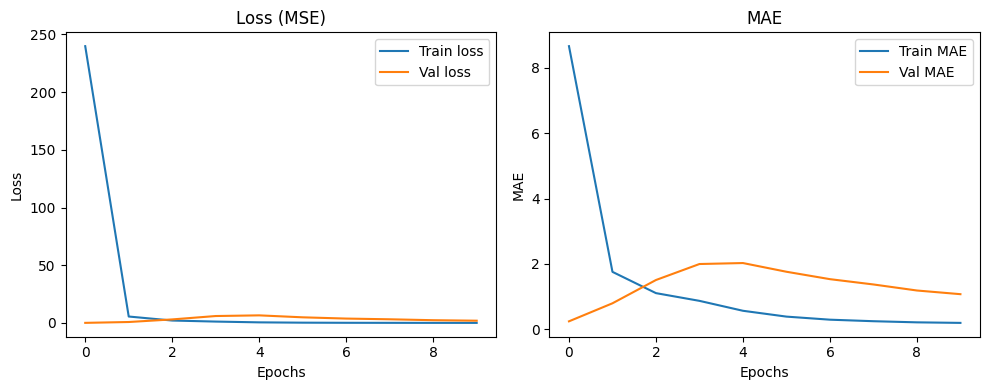

In [11]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()